In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import json
import numpy as np
from numpy import expand_dims
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
import matplotlib.pyplot as plt 

%matplotlib inline

Load a model for a prediction purposes with "imagenet" pre-trained weights included

In [2]:
model = MobileNetV2(weights = 'imagenet', include_top=True)
model.summary()

14540800/14536120 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________

Load the imagenet class names and indices JSON file and save only the class names in a list

In [4]:
CLASS_INDEX = json.load(open('./imagenet_class_index.json'))
classlabel = []
for ind in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(ind)][1])
    
print("Number of classes: ", len(classlabel))

Number of classes:  1000


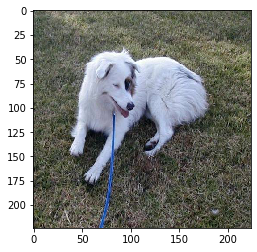

In [5]:
org_img = load_img("./samples_imgs/dogs_00008.jpg", target_size=(224, 224))
plt.imshow(org_img)
plt.show()

In [6]:
img = img_to_array(org_img)
img = expand_dims(img, 0)
img = preprocess_input(img)
preds = model.predict(img)
print("predicted: ", decode_predictions(preds, top=3)[0])

# sort the predicted classes indices in descending order and visualize only the top 5 classes
class_idxs_sorted = np.argsort(preds.flatten())[::-1]
topNClasses = 5 

# iterate over only top 5 classes and show the results
for i, idx in enumerate(class_idxs_sorted[:topNClasses]):
    print("Top {} predicted class probs: {:18} index({}) = {:5.3f}".format(i + 1, classlabel[idx], idx, preds[0, idx]))

predicted:  [('n02111500', 'Great_Pyrenees', 0.8880308), ('n02104029', 'kuvasz', 0.03452089), ('n02090622', 'borzoi', 0.01980215)]
Top 1 predicted class probs: Great_Pyrenees     index(257) = 0.888
Top 2 predicted class probs: kuvasz             index(222) = 0.035
Top 3 predicted class probs: borzoi             index(169) = 0.020
Top 4 predicted class probs: Samoyed            index(258) = 0.014
Top 5 predicted class probs: collie             index(231) = 0.002


Using keras-vis library for visualizing the important regions in the image for predicting the class. 
We are using a Gradient Class Activation Map (grad-CAM) method for that. 

In [7]:
from vis.utils import utils
from vis.visualization import visualize_cam, overlay

Using TensorFlow backend.
/anaconda3/envs/tf_venv_2.1/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/envs/tf_venv_2.1/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Two most important parameters which are required are: (i) last conv layer (UxVxK) index (penultimate_layer_idx) which should be before flattening or GAP layer. It could be only after CONV or CONV+BN or CONV+BN+RELU layer. and (ii) last layer index (layer_idx) just before the softmax layer because softmax layer is a non-linear function which can destroy the linear mapping between the spatial information contained in the last conv layer and the "y" values. 

Therefore, it is important to check manually the layer names (last conv layer and last layer just before the softmax) 
from the model summary!

In [8]:
# get the last closest layer to the output but before the softmax layer. It's length should be the same as the 
# number of output classes
layer_idx = utils.find_layer_idx(model, 'global_average_pooling2d')  

# get the last conv layer (in the shape of UxVxK) which linear relationship with the output classes need to be 
# visualized. Note: it could be any CONV layer inside of the model, the results are worse because they only focus on 
# less semantic local features while on other hand last CONV layer has highest semantic class-specific information 
# in the image. 
penultimate_layer_idx = utils.find_layer_idx(model, 'Conv_1') # Conv_1_bn or out_relu 

In [9]:
# compute the Grad-CAM for the last conv layer.
grads = visualize_cam(model, 
                      layer_idx, 
                      filter_indices=np.argmax(preds), 
                      seed_input=img, 
                      penultimate_layer_idx=penultimate_layer_idx, 
                      backprop_modifier=None)

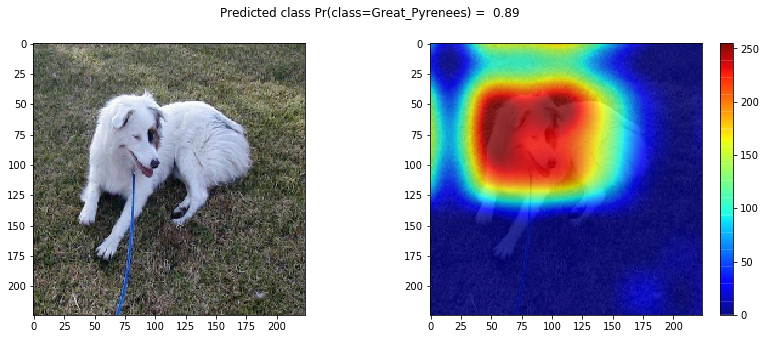

In [10]:
# plot and visualize Grad-CAM for the class with the highest prediction.
def plot_map(grads, _img, class_idx):    
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Predicted class Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      preds[0,class_idx]))
    
plot_map(grads, org_img, class_idxs_sorted[0])

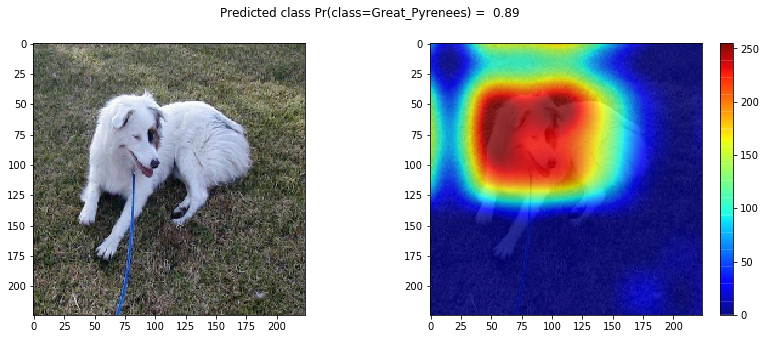

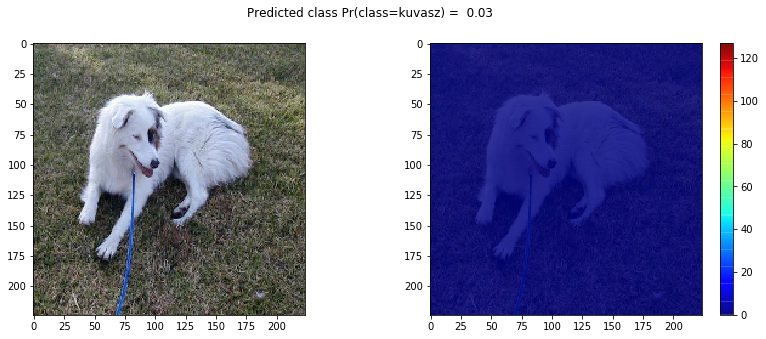

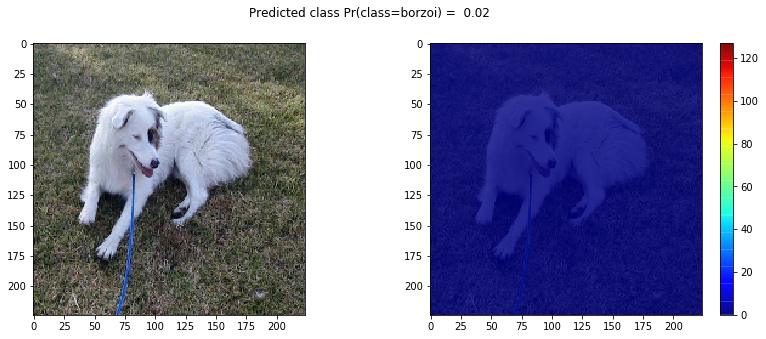

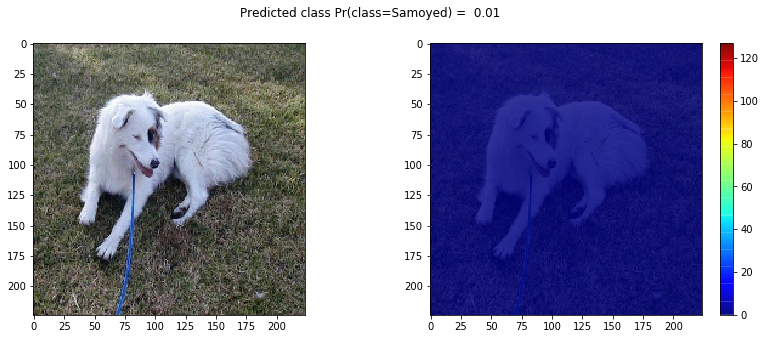

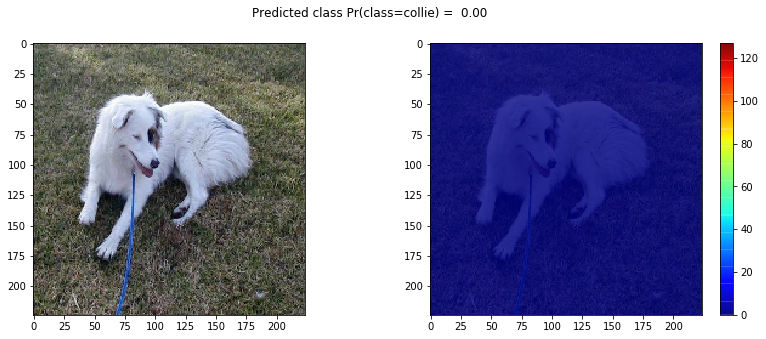

In [11]:
# plot and visualize now the top 5 predicted classes 
for class_idx in class_idxs_sorted[:topNClasses]:
    grads  = visualize_cam(model, 
                           layer_idx, 
                           filter_indices=class_idx, 
                           seed_input=img,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads, org_img, class_idx)